In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

plt.style.use('ggplot')

### Markov Chains

A Markov chain is a mathematical object consisting of a sequence of states and a set of probabilities describing transitions among those states.  In order for a chain of states to be Markovian, the probability of arriving at the current state must depend only on the previous state.  

A discrete-time Markov chain is a sequence of random variables X1, X2, X3, ... with the Markov property, namely that the probability of moving to the next state depends only on the present state and not on the previous states:

$Pr(X_{n+1}=x|X_{1}=x_{1}, X_{2}=x_{2},...,X_{n}=x_{n}) = Pr(X_{n+1}=x|X_{n}=x_{n})$

if both conditional probabilities are well defined, that is, if 
$Pr(X_{1}=x_{1},\ldots ,X_{n}=x_{n})>0$

Given a Markov chain, we can perform a random walk by choosing a starting point and moving to other states according to some transition probabilities.  If we can find a Markov chain with transition probabilities proportional to the posterior distribution we want to sample from in a Bayesian analysis, sampling becomes a matter of moving between states in the Markov chain.  

So how do we find such a Markov chain if we don't know our posterior distribution in the first place? By using the **detailed balance condition**.  This is basically the idea that we should be able to move in a reversible manner.  Moving from state i to state j should have the same probability as moving from state j to state i.  So in a nutshell, what this all means is that if we can create a Markov chain satisfying the detailed balance requirement, we can sample from the chain and guarantee we will get samples from the correct distribution!  The most popular method that guarantees detailed balance is the **Metropolis-Hastings algorithm**.  

### Metropolis-Hastings 

Metropolis-Hastings can be understood by considering an analogy.  Suppose we are sitting on a lake and want to find the volume of water that the lake contains and determine where the lake is deepest.  We recruit two friends using a simple boat to determine these values and perform the following actions:

- 1. Initialize the measuring by choosing a random place in the lake and stop the boat at it.
- 2. Use a measuring stick to measure the depth of the lake in that spot.
- 3. Move the boat to another random point and take a new measurement.
- 4. Compare the two measurements.  If the new spot is deeper, we record the value and repeat from step 2.  If the spot is not deeper than the old one, we can either accept or reject the value.  If we accept, we write down the depth of the new spot and repeat from step 2.  If we reject, we go back to the old spot and write down the value for the depth of the old spot again.  

To accept or reject, we use the **Metropolis-Hastings criteria**.  We accept the new spot with a probability proportional to the ratio of the depth of the new and old spots.  If we follow this procedure, we not only get the total volume of our lake and the deepest point, but we also get an approximate distribution of the bottom of the lake!  

More formally, we have the following steps:

- 1. Choose an initial value, either randomly or with an educated guess, for the parameter $x_{i}$.  
- 2. Choose a new parameter value for $x_{i+1}$, sampling from an easy-to-sample distribution like a Gaussian.  
- 3. Compute the probability of accepting a new parameter value by using the Metropolis-Hastings criteria: $p(x_{i+1}|x_{i})$ = min $(1, \frac{p(x_{i+1})q(x_{i}|x_{i+1})}{p(x_{i})q(x_{i+1}|x_{i})})$
- 4. If the probability computed on step 3 is larger than the value take from a uniform distribution on the interval [0,1], we accept the new state, otherwise we stay in the old state.  
- 5. We iterate through step 2 to obtain enough samples.  

So there we have it! The algorithm is not too complicated.  Let's set it up:

In [2]:
def metropolis(func, steps=10000):
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

So this is the basic algorithm.  We select a function to sample from and we perform 10,000 steps.  We start from the mean of our distribution and calculate the probability.  We then loop through our range of steps and set `new_x` to be `old_x` plus a value drawn from a normal distribution with mean 0 and standard deviation 0.5. We calculate the probability.  We divide the new probability by the old probability and if it's bigger than a randomly drawn value in the interval [0,1], then we save it for that entry in `samples`.  We then set `old_x` equal to `new_x` to change positions and `old_prob` to `new_prob`.  If our acceptance value is not higher than the randomly drawn number, we save `old_x`.   So let's see this now in action using a beta function with parameters $\alpha = 0.4$ and $\beta = 2$:

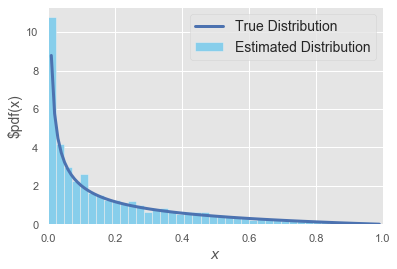

In [25]:
func = stats.beta(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'b-', lw=3, label='True Distribution')
plt.hist(samples, bins=40, density=True, color = "skyblue", label='Estimated Distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)', fontsize=14)
plt.legend(fontsize=14);

As we can see above, the algorithm gives us a very good approximation to our true distribution.  